# **1 . Set up environment**

First, install all the packages needed

In [ ]:
!pip install -q kaggle
from google.colab import files
! rm kaggle.json
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove 'kaggle.json': No such file or directory


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c inf8245e-fall-2022
!unzip inf8245e-fall-2022.zip
!ls

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open inf8245e-fall-2022.zip, inf8245e-fall-2022.zip.zip or inf8245e-fall-2022.zip.ZIP.
sample_data


Import all packages necessary

In [ ]:
# Global
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from pathlib import Path

from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report, confusion_matrix

# Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder

import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV,train_test_split

from sklearn.decomposition import PCA

# Models
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


# **2. Load the data**

Load the train data

In [ ]:
data_train = pd.read_csv('train.csv', na_values=['Insert Band Name', 'Insert Band Genre', 'Insert Band Country of Origin'])

Load the test data

In [ ]:
data_test = pd.read_csv('test.csv', na_values=['Insert Band Name', 'Insert Band Genre', 'Insert Band Country of Origin'])

**Defining data variables**

Simple Dataset

In [ ]:
X_train = data_train.drop(columns=['Concert Enjoyment', 'Id']) #add 'Concert Goer Id' if using basic dataset
y_train = data_train['Concert Enjoyment']

X_test = data_test.drop(columns=['Id'])#add 'Concert Goer Id' if using basic dataset

New Dataset from Prepro.csv

In [ ]:
#data = pd.read_csv('prepro.csv', na_values=['Insert Band Name', 'Insert Band Genre', 'Insert Band Country of Origin'])
#data_train = data.iloc[:170000]
#data_test = data.iloc[170000:]

#X_train = data_train.drop(columns=['Concert Goer ID','Unnamed: 0'])

data_originel = pd.read_csv('train.csv', na_values=['Insert Band Name', 'Insert Band Genre', 'Insert Band Country of Origin'])
#y_train = data_originel['Concert Enjoyment']

#X_test = data_test.drop(columns=[ 'Concert Goer ID'])

Validation split

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# **3. Missing values full preprocessing**

In [ ]:
enc = LabelEncoder()
categ_features = ['Band Name', 'Band Genre', 'Band Country of Origin', 'Concert Goer Country of Origin','Concert Goer ID']
for feature in categ_features:

  enc.fit(X_train[feature])
  le_dict = dict(zip(enc.classes_, enc.transform(enc.classes_)))
  le_dict[np.nan] = np.nan
  X_train[feature] = X_train[feature].apply(lambda x: le_dict.get(x, le_dict.get(np.nan)))
  X_test[feature] = X_test[feature].apply(lambda x: le_dict.get(x, le_dict.get(np.nan)))

In [ ]:
new_df = X_train.append(X_test)
# We could apply the bloc below on new_df

In [ ]:
new_df
new_df=new_df.reset_index(drop=True)

In [ ]:
# Deduct some values for those columns below

columns = ['Band Genre', 'Band Country of Origin', 'Band Debut']

for column in columns:
  print(new_df[column].isna().sum())
  indexes = new_df[new_df[column].isna()].index
  for e in indexes:
    name = new_df.loc[e,'Band Name']

    liste = new_df[new_df['Band Name'] == name][column].unique()
    if len(liste) != 0:
      liste = liste[~np.isnan(liste)]
      new_df.at[e, column] = liste[0]



1122
1153
1014


In [ ]:
# Fill Concert ID nan values
print(new_df['Concert ID'].isna().sum())
list_csi_index = new_df[new_df['Concert ID'].isna()].index
for k in range (len(list_csi_index)):
    if len((new_df[(new_df['Band Name'] == new_df.iloc[list_csi_index[k]]['Band Name']) & (new_df['Band Genre'] == new_df.iloc[list_csi_index[k]]['Band Genre']) & \
                    (new_df['Inside Venue'] == new_df.iloc[list_csi_index[k]]['Inside Venue']) & (new_df['Rain'] == new_df.iloc[list_csi_index[k]]['Rain']) & \
                    (new_df['Concert Attendance'] == new_df.iloc[list_csi_index[k]]['Concert Attendance']) & (new_df['Concert Goer ID'] != new_df.iloc[list_csi_index[k]]['Concert Goer ID'])])) > 0 :
        val = (new_df[(new_df['Band Name'] == new_df.iloc[list_csi_index[k]]['Band Name']) & (new_df['Band Genre'] == new_df.iloc[list_csi_index[k]]['Band Genre']) & \
            (new_df['Inside Venue'] == new_df.iloc[list_csi_index[k]]['Inside Venue']) & (new_df['Rain'] == new_df.iloc[list_csi_index[k]]['Rain']) & \
                (new_df['Concert Attendance'] == new_df.iloc[list_csi_index[k]]['Concert Attendance']) & (new_df['Concert Goer ID'] != new_df.iloc[list_csi_index[k]]['Concert Goer ID'])]['Concert ID'].value_counts()).index[0]
        new_df.loc[list_csi_index[k], 'Concert ID']=val
print(new_df['Concert ID'].isna().sum())

1028
24


In [ ]:
#Fill Concert Attendance nan values
print(new_df['Concert Attendance'].isna().sum())
liste_csa = list(new_df[new_df['Concert Attendance'].isna()]['Concert ID'])
liste_csa_index = new_df[new_df['Concert Attendance'].isna()].index
for k in range (len(liste_csa)):
    if len(new_df[new_df['Concert ID']==liste_csa[k]]['Concert Attendance']) >0 :
        val = (new_df[new_df['Concert ID']==liste_csa[k]]['Concert Attendance'].value_counts()).index[0]
        new_df.loc[liste_csa_index[k], 'Concert Attendance'] = val
print(new_df['Concert Attendance'].isna().sum())

1047
5


In [ ]:
liste = new_df['Concert Attendance'].unique()
liste.sort()
liste = [x for x in liste if str(x) != 'nan']
indexes = new_df[new_df['Concert Attendance'] >= 1000000]['Concert Attendance'].index
for i in indexes:
  new_df.at[i, 'Concert Attendance'] = liste[(int)(len(liste)/2)]
liste = new_df['Concert Attendance'].unique()
liste.sort()
print(liste)


[5.40000e+01 1.48000e+02 4.03000e+02 1.09600e+03 2.98000e+03 8.10300e+03
 2.20260e+04 5.98740e+04 1.62754e+05 5.40000e+05         nan]


In [ ]:
# Handle not replaced nan values
for name in ['Concert ID',	'Concert Attendance']:
  new_df[name].fillna(-1, inplace = True)

In [ ]:
#Fill Inside Venue nan values
print(new_df['Inside Venue'].isna().sum())
liste_iv = list(new_df[new_df['Inside Venue'].isna()]['Concert ID'])
liste_iv_index = new_df[new_df['Inside Venue'].isna()].index
for k in range (len(liste_iv)):
    if len(new_df[new_df['Concert ID']==liste_iv[k]]['Inside Venue'])>0:
        val = (new_df[new_df['Concert ID']==liste_iv[k]]['Inside Venue'].value_counts()).index[0]
        new_df.loc[liste_iv_index[k], 'Inside Venue'] = val
print(new_df['Inside Venue'].isna().sum())

1004
0


In [ ]:
#Fill Rain nan values
print(new_df['Rain'].isna().sum())
liste_r = list(new_df[new_df['Rain'].isna()]['Concert ID'])
liste_r_index = new_df[new_df['Rain'].isna()].index
for k in range (len(liste_r)):
  if len(new_df[new_df['Concert ID']==liste_r[k]]['Rain'])>0:
    val = (new_df[new_df['Concert ID']==liste_r[k]]['Rain'].value_counts()).index[0]
    new_df.loc[liste_r_index[k], 'Rain'] = val
print(new_df['Rain'].isna().sum())

1004
0


In [ ]:
#Handle Seated nan values
print(new_df[new_df['Concert ID'] == 0]['Seated'].unique())
print(new_df['Seated'].isna().sum())
for name in ['Seated']:
  new_df[name].fillna(-1, inplace = True)
print(new_df['Seated'].isna().sum())

[True False]
974
0


In [ ]:
#Fill personality traits nan values
'''for e in new_df['Concert Goer ID'].unique():
  print(new_df[new_df['Concert Goer ID'] == e]['Personnality Trait 3'].unique())
for e in new_df['Concert Goer ID'].unique():
  print(new_df[new_df['Concert Goer ID'] == e]['Personnality Trait 3'].unique())
'''

print(new_df['Personnality Trait 2'].isna().sum())
for e in new_df['Concert Goer ID'].unique():
  liste = new_df[new_df['Concert Goer ID'] == e]['Personnality Trait 2'].unique()
  indexes = new_df[new_df['Concert Goer ID'] == e].index
  liste = liste[~np.isnan(liste)]
  if len(liste) > 0:
    closest_zero = min(liste, key=lambda x:abs(x))
  for i in indexes:
    new_df.at[i, 'Personnality Trait 2'] = closest_zero

print(new_df['Personnality Trait 2'].isna().sum())


1002
8


In [ ]:
liste = new_df['Personnality Trait 2'].unique()
liste.sort()
liste = [x for x in liste if str(x) != 'nan']
indexes = new_df[new_df['Personnality Trait 2'] >= 10]['Personnality Trait 2'].index
for i in indexes:
  new_df.at[i, 'Personnality Trait 2'] = liste[(int)(len(liste)/2)]
liste = new_df['Personnality Trait 2'].unique()
liste.sort()
print(liste)

[-4.41236188 -3.63038637 -3.12006903 ...  3.34884639  3.85965486
         nan]


In [ ]:
'''for e in new_df['Concert Goer ID'].unique():
  print(new_df[new_df['Concert Goer ID'] == e]['Personnality Trait 4'].unique())'''

print(new_df['Personnality Trait 4'].isna().sum())
liste_r = list(new_df[new_df['Personnality Trait 4'].isna()]['Concert Goer ID'])
liste_r_index = new_df[new_df['Personnality Trait 4'].isna()].index
for k in range (len(liste_r)):
  if len(new_df[new_df['Concert Goer ID']==liste_r[k]]['Personnality Trait 4'])>0:
    val = (new_df[new_df['Concert Goer ID']==liste_r[k]]['Personnality Trait 4'].value_counts()).index[0]
    new_df.loc[liste_r_index[k], 'Personnality Trait 4'] = val
print(new_df['Personnality Trait 4'].isna().sum())

1003
3


In [ ]:
'''for e in new_df['Concert Goer ID'].unique():
  print(e, new_df[new_df['Concert Goer ID'] == e]['Concert Goer Age'].unique())

'''
print(new_df['Concert Goer Age'].isna().sum())
liste_r = list(new_df[new_df['Concert Goer Age'].isna()]['Concert Goer ID'])
liste_r_index = new_df[new_df['Concert Goer Age'].isna()].index
for k in range (len(liste_r)):
    if len(new_df[new_df['Concert ID']==liste_r[k]]['Concert Goer Age'])>0:
      val = (new_df[new_df['Concert Goer ID']==liste_r[k]]['Concert Goer Age'].value_counts()).index[0]
      new_df.loc[liste_r_index[k], 'Concert Goer Age'] = val
print(new_df['Concert Goer Age'].isna().sum())

979
496


In [ ]:
#for e in new_df['Concert Goer ID'].unique():
#  print(new_df[new_df['Concert Goer ID'] == e]['Height (cm)'].unique())

In [ ]:
print(new_df['Height (cm)'].isna().sum())
liste_r = list(new_df[new_df['Height (cm)'].isna()]['Concert Goer ID'])
liste_r_index = new_df[new_df['Height (cm)'].isna()].index
for k in range (len(liste_r)):
    if len(new_df[new_df['Concert ID']==liste_r[k]]['Height (cm)'])>0:
      val = (new_df[new_df['Concert Goer ID']==liste_r[k]]['Height (cm)'].value_counts()).index[0]
      new_df.loc[liste_r_index[k], 'Height (cm)'] = val
print(new_df['Height (cm)'].isna().sum())

987
506


In [ ]:
#for e in new_df['Concert Goer ID'].unique():
#  print(new_df[new_df['Concert Goer ID'] == e]['Concert Goer Country of Origin'].unique())

In [ ]:
print(new_df['Concert Goer Country of Origin'].isna().sum())
liste_r = list(new_df[new_df['Concert Goer Country of Origin'].isna()]['Concert Goer ID'])
liste_r_index = new_df[new_df['Concert Goer Country of Origin'].isna()].index
for k in range (len(liste_r)):
    if len(new_df[new_df['Concert ID']==liste_r[k]]['Concert Goer Country of Origin'])>0:
      val = (new_df[new_df['Concert Goer ID']==liste_r[k]]['Concert Goer Country of Origin'].value_counts()).index[0]
      new_df.loc[liste_r_index[k], 'Concert Goer Country of Origin'] = val
print(new_df['Concert Goer Country of Origin'].isna().sum())

1020
518


In [ ]:
print(new_df.isna().sum().sum())

5740


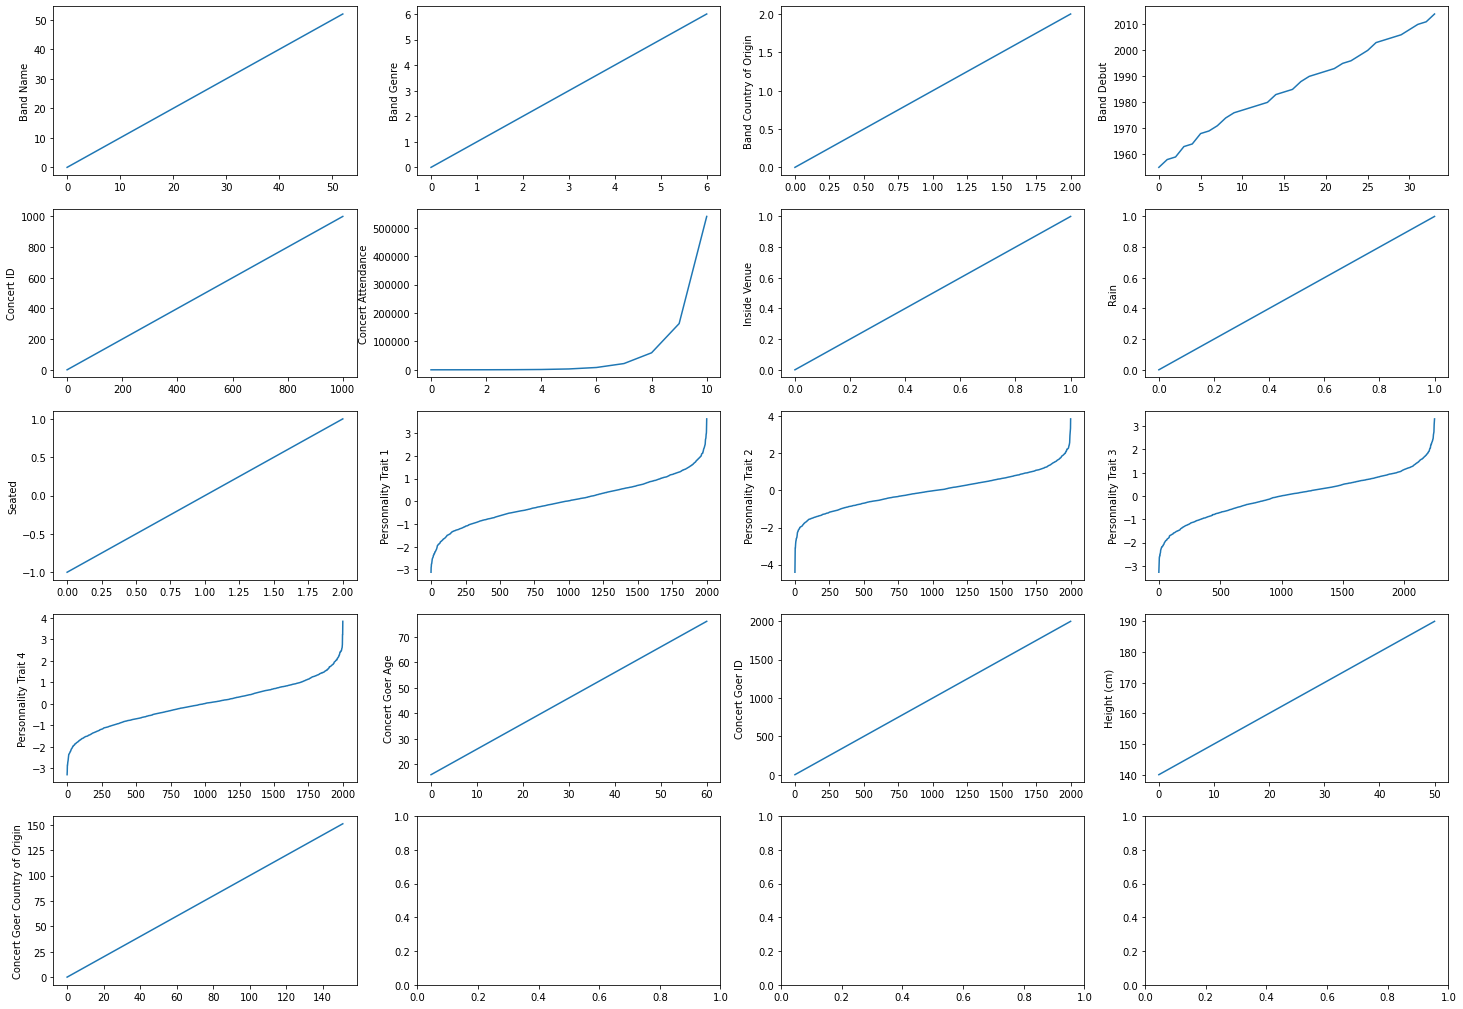

In [ ]:
from matplotlib import pyplot as plt
import math
i,j=0,0
PLOTS_PER_ROW = 4
fig, axs = plt.subplots(math.ceil(len(new_df.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(25.0, 18.0))
for column in new_df.columns:
  liste = new_df[column].unique()
  liste.sort()
  indexes = [i for i in range(len(liste))]
  axs[i][j].plot(liste)
  axs[i][j].set_ylabel(column)
  j += 1
  if j%PLOTS_PER_ROW==0:
    i+=1
    j=0
plt.show()

For validation

In [ ]:
new_df[14:16]

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin
14,29.0,5.0,2.0,1992.0,817.0,403.0,False,False,True,NaN,0.427680,-0.216587,-0.984782,72.0,703.0,172.0,24.0
15,NaN,1.0,0.0,2005.0,628.0,22026.0,True,False,False,-1.280309,0.901388,0.672355,-0.155070,76.0,1550.0,144.0,24.0


In [ ]:
list(y_train)

['Did Not Enjoy',
 'Enjoyed',
 'Did Not Enjoy',
 'Worst Concert Ever',
 'Did Not Enjoy',
 'Best Concert Ever',
 'Enjoyed',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Best Concert Ever',
 'Did Not Enjoy',
 'Worst Concert Ever',
 'Enjoyed',
 'Worst Concert Ever',
 'Worst Concert Ever',
 'Enjoyed',
 'Enjoyed',
 'Best Concert Ever',
 'Enjoyed',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Enjoyed',
 'Did Not Enjoy',
 'Enjoyed',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Enjoyed',
 'Best Concert Ever',
 'Did Not Enjoy',
 'Enjoyed',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Enjoyed',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Enjoyed',
 'Enjoyed',
 'Enjoyed',
 'Best Concert Ever',
 'Did Not Enjoy',
 'Enjoyed',
 'Enjoyed',
 'Best Concert Ever',
 'Did Not Enjoy',
 'Enjoyed',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Did Not Enjoy',
 'Worst Concert Ever',
 'Enjoyed',
 'Enjoyed',
 'Enjoyed',
 'Did Not

In [ ]:
X_train = new_df.iloc[:170000].reset_index()
X_train.insert(17, 'Concert Enjoyment',list(y_train))

In [ ]:
X_train.to_csv('post_pro')

In [ ]:
#For validation
X_train = new_df.iloc[:136000].reset_index()
X_test = new_df.iloc[136000:170000].reset_index()

for name in X_train.columns:
  X_train[name].fillna(X_train[name].mean(), inplace = True)
  X_test[name].fillna(X_test[name].mean(), inplace = True)

For Kaggle submission

In [ ]:
X_train = new_df.iloc[:170000].reset_index()
X_test = new_df.iloc[170000:].reset_index()

for name in X_train.columns:
  X_train[name].fillna(X_train[name].mean(), inplace = True)
  X_test[name].fillna(X_test[name].mean(), inplace = True)

In [ ]:
X_train = X_train.drop(columns = ['Concert Goer ID', 'index'])
X_test = X_test.drop(columns = ['Concert Goer ID','index'])

# **4 . Basic preprocessing**

Encode categorical columns with label encoder

In [ ]:
enc = LabelEncoder()
categ_features = ['Band Name', 'Band Genre', 'Band Country of Origin', 'Concert Goer Country of Origin']
for feature in categ_features:
  enc.fit(X_train[feature])
  le_dict = dict(zip(enc.classes_, enc.transform(enc.classes_)))
  X_train[feature] = X_train[feature].apply(lambda x: le_dict.get(x, '<unknown_value>'))
  X_test[feature] = X_test[feature].apply(lambda x: le_dict.get(x, '<unknown_value>'))


Filtering Nan values for boolean features, by default = 0

In [ ]:
for name in ['Rain','Inside Venue', 'Seated']:
  X_train[name].fillna(0, inplace = True)
  X_test[name].fillna(0, inplace = True)

Get rid of outliers with function clip, need to be done before filling Nan values witht the mean value for 'Concert Attendance' and 'Personnality Trait 2'


In [ ]:
for name in ['Concert Attendance', 	'Personnality Trait 2']:
  X_train[name] = np.clip(X_train[name],X_train[name].mean()-3*X_train[name].std() ,X_train[name].mean()+3*X_train[name].std())
  X_test[name] = np.clip(X_test[name],X_test[name].mean()-3*X_test[name].std() ,X_test[name].mean()+3*X_test[name].std())


Filtering NaN values for numerical features

In [ ]:
for name in ['Band Debut',	'Concert ID',	'Concert Attendance', 'Personnality Trait 1',	'Personnality Trait 2',	\
                        'Personnality Trait 3',	'Personnality Trait 4',	'Concert Goer Age',	'Height (cm)']:
  X_train[name].fillna(X_train[name].mean(), inplace = True)
  X_test[name].fillna(X_test[name].mean(), inplace = True)

#instead of doing this, we could use complete case analysis, which means considering only data without missing data

Filtering Nan values for categorical features, take automatically the previous value in the column

In [ ]:
for name in ['Band Name', 'Band Genre', 'Band Country of Origin', 'Concert Goer Country of Origin']:
  X_train[name].fillna(method="ffill", inplace = True)
  X_test[name].fillna(method="ffill", inplace = True)

Principle Component Analysis

In [ ]:
pca = PCA(n_components=15)

X_train = pca.fit_transform(X_train)
X_train = pd.DataFrame(X_train)

# **5. Normalize Data**

Normalize the data, using StandardScaler or RobustScaler(problème les valeurs ne sont pas entre 0 et 1)

In [ ]:
num_features = ['Band Debut',	'Concert ID',	'Concert Attendance', 'Personnality Trait 1',	'Personnality Trait 2',	\
                        'Personnality Trait 3',	'Personnality Trait 4',	'Concert Goer Age',	'Height (cm)']
#sc = RobustScaler(quantile_range = (0.25,0.75))
sc = StandardScaler()
X_train[num_features] = sc.fit_transform(X_train[num_features])

In [ ]:
X_train

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Height (cm),Concert Goer Country of Origin
0,43.0,3.0,2.0,-0.605232,1.388671,-0.474828,False,False,-1,0.303363,-0.949506,-0.924236,-1.630268,-1.029605,-1.719877,104.0
1,2.0,4.0,2.0,-1.094350,0.803031,-0.531271,True,False,True,-2.124032,0.039397,-1.888886,0.604670,-0.227155,-0.465369,143.0
2,33.0,6.0,0.0,-1.889167,1.430255,2.607281,False,False,True,-0.520952,2.015810,-0.047106,-1.256363,1.205792,-0.395674,144.0
3,14.0,5.0,2.0,0.373005,0.709467,-0.376003,False,True,False,-0.898959,1.057541,-0.330601,-1.143357,-1.717420,-1.022928,24.0
4,2.0,4.0,2.0,-1.094350,-1.400916,-0.531271,False,False,False,-0.833200,-1.160337,-0.026757,0.962125,0.689931,0.092190,143.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135995,28.0,5.0,2.0,-1.094350,0.227787,0.622682,True,False,False,-0.189770,-1.515999,-1.096649,1.877871,-0.857652,-0.535064,144.0
135996,26.0,1.0,2.0,0.739843,0.913922,-0.524539,False,True,False,-0.766232,1.192101,-0.738157,1.361355,1.205792,-1.719877,24.0
135997,26.0,1.0,2.0,0.739843,-1.255373,-0.107422,False,True,True,1.154696,-0.281392,1.008652,0.832373,-1.029605,0.370970,144.0
135998,16.0,1.0,2.0,0.128446,-1.563787,-0.474828,False,True,True,-0.820807,0.120616,0.311966,-0.382072,-0.341791,1.067918,144.0


# **6 . Model selection**

Hyperparameter tuning

In [ ]:
# https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# https://scikit-learn.org/stable/modules/model_evaluation.html
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
"""
estimators = [
    ('rf', RandomForestClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('svc', SVC())
]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
"""

oversample = SMOTE(k_neighbors=5)
#X_train, y_train = oversample.fit_resample(X_train, y_train)
#X_train, y_train = oversample.fit_resample(X_train, y_train)

#RandomForest Classifier
clf = RandomForestClassifier(min_samples_leaf=10 ,n_estimators= 60, max_features='log2' , max_depth=100, random_state=0, n_jobs=-1)
#RF = RandomForestClassifier()
#parameters = {'min_samples_leaf':[1,10,20], 'n_estimators':[10,50,100,150], 'max_features':('log2', 'sqrt'), 'max_depth':[100, 'None']}
#clf = GridSearchCV(RF, parameters, n_jobs=-1)

#ExtraBoostingClassifier
#https://xgboost.readthedocs.io/en/latest/get_started.html
hgbc = HistGradientBoostingClassifier(l2_regularization = 0 ,categorical_features=[1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1])


In [ ]:
hgbc = HistGradientBoostingClassifier()
X_train_2=X_train.iloc[:136000]
X_train_3=X_train.iloc[136000:170000]
y_train_2 = y_train.iloc[:136000]
y_test= y_train.iloc[136000:170000]
hgbc.fit(X_train_2,y_train_2)
y_pred = hgbc.predict(X_train_3)
f1 = f1_score(y_test, y_pred, average='micro')

In [ ]:
clf = RandomForestClassifier(min_samples_leaf=10 ,n_estimators= 60, max_features='log2' , max_depth=100, random_state=0, n_jobs=-1)
X_train_2=X_train.iloc[:136000]
X_train_3=X_train.iloc[136000:170000]
y_train_2 = y_train.iloc[:136000]
y_test= y_train.iloc[136000:170000]
clf.fit(X_train_2,y_train_2)
y_pred = clf.predict(X_train_3)
f1 = f1_score(y_test, y_pred, average='micro')

In [ ]:
f1

0.6636764705882353

# **7 . Training**

Train the model

In [ ]:
y_train_2 = y_train.iloc[:136000]
y_test= y_train.iloc[136000:170000]

In [ ]:
hgbc.fit(X_train,y_train_2)

ValueError: ignored

Report important features

In [ ]:
"""col = list(X_train.columns)"""

In [ ]:
"""from matplotlib import pyplot

importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d %s, Score: %.5f' % (i,col[i],v))
 # plot feature importance
pyplot.figure(figsize=[25.0, 5.0])
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()"""

# **8 . Compute predictions**

Compute predictions

In [ ]:
#Be careful, labelencoder can break if there is some categorical data in the test set that was unseen in the train set :https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
# For the moment it's ok cause test set is a part of our training set so we perform labelencoder before splitting the set, but it could be an issue when working with a different set for the test

X_test[num_features] = sc.transform(X_test[num_features])
#X_test = pca.transform(X_test)
#X_test = pd.DataFrame(X_test)
y_pred = hgbc.predict(X_test)

NameError: ignored

# **9 . Export results**

In [ ]:
submission = pd.DataFrame(data_test['Id'].copy())
submission['Predicted'] = y_pred
print(submission)

In [ ]:
filepath = Path('./out_test.csv')
submission.to_csv(filepath, index=False)
files.download(filepath)

Determine some metrics to visualize validation performance

In [ ]:
f1 = f1_score(y_test, y_pred, average='micro')
print(confusion_matrix(y_test, y_pred))
print(f1)

[[  967    41  2357     5]
 [   27  9980  2942   619]
 [  496  2990 10167    14]
 [    3  1935    29  1428]]
0.663


Best Kaggle score 0.6596764705882353 obtained with clip at 3sigma before fillna for concert attendance \
Full preprocessing + RobustScaler + RF = 0.6617647058823529\
Full preprocessing + StandardScaler + HGBC = 0.663

In [ ]:
f1 = f1_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("f1 score is ", f1)
print("recall score is ", recall)
print("accuracy score is ", accuracy)

print(report)

# **10. Autre**


In [ ]:
def delcol(liste):
    data_prepro= pd.read_csv(r'prepro.csv', na_values=['Insert Band Name', 'Insert Band Genre', 'Insert Band Country of Origin'])
    data_train = pd.read_csv(r'train.csv', na_values=['Insert Band Name', 'Insert Band Genre', 'Insert Band Country of Origin'])
    df_ret = data_prepro.iloc[:170000]
    df_ret = df_ret.drop(columns=['Unnamed: 0','Seated'])
    df_2 = data_train['Concert Enjoyment']
    df_ret = df_ret.drop(columns=liste)
    return(df_ret,df_2)

def compute_f1(x,y):
    clf = RandomForestClassifier(min_samples_leaf=10 ,n_estimators= 60, max_features='log2' , max_depth=100, random_state=0, n_jobs=-1)
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(x, y, test_size=0.2, random_state=42)
    clf.fit(X_train_2,y_train_2)
    y_pred=clf.predict(X_test_2)
    f1=f1_score(y_test_2, y_pred, average='micro')
    return(f1)

In [ ]:
ls = []
cols = [ 'Band Name', 'Band Genre', 'Band Country of Origin',
       'Band Debut', 'Concert ID', 'Concert Attendance', 'Inside Venue',
       'Rain', 'Personnality Trait 1', 'Personnality Trait 2',
       'Personnality Trait 3', 'Personnality Trait 4', 'Concert Goer Age',
       'Concert Goer ID', 'Height (cm)', 'Concert Goer Country of Origin']
for k in range(len(cols)):
    for l in range (k+1, len(cols)-1):


                ls+= [[cols[k],cols[l]]]

In [ ]:
"""ls = []
cols = [ 'Band Name', 'Band Genre', 'Band Country of Origin',
       'Band Debut', 'Concert ID', 'Concert Attendance', 'Inside Venue',
       'Rain', 'Personnality Trait 1', 'Personnality Trait 2',
       'Personnality Trait 3', 'Personnality Trait 4', 'Concert Goer Age',
       'Concert Goer ID', 'Height (cm)', 'Concert Goer Country of Origin']
for k in range(len(cols)):



                ls+= [cols[k]]"""

In [ ]:
score=[]
for k in range(len(ls)):
    print(ls[k])
    bip = delcol(ls[k])
    val = compute_f1(bip[0],bip[1])
    print(val)
    score.append(val)

pour une seule colonne retirée, max = 0.6525294117647059, colonne 'Concert Goer ID'

# **11. Suite**

In [ ]:
# IMPORTS
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
# CONSTANTS
CLASS = 'Concert Enjoyment'
FILE = 'post_pro'

df = pd.read_csv(FILE)
df=df.drop(columns=['Unnamed: 0','index'])

# SUFFLE THE DATA
df = df.sample(frac=1, random_state=1).reset_index(drop=True)   # shuffle dataset
df.iloc[25:29]

,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Enjoyment,Concert Goer Country of Origin
25,49.0,2.0,2.0,1958.0,467.0,162754.0,True,False,False,0.455615,-0.661357,-0.900125,0.835057,64.0,853.0,161.0,Did Not Enjoy,144.0
26,20.0,5.0,1.0,1992.0,891.0,59874.0,False,False,False,0.475288,-0.412220,0.060375,-0.120945,31.0,632.0,180.0,Enjoyed,24.0
27,14.0,5.0,2.0,1992.0,808.0,403.0,True,False,True,2.107145,-0.477004,0.457862,0.338422,60.0,429.0,143.0,Did Not Enjoy,144.0
28,NaN,3.0,2.0,2005.0,639.0,403.0,False,False,False,1.635914,0.335297,0.521544,0.947984,31.0,1311.0,158.0,Best Concert Ever,24.0


In [ ]:
df = pd.read_csv(FILE)
df[df['Band Name'].isna()]

,Unnamed: 0,index,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Enjoyment,Concert Goer Country of Origin
15,15,15,NaN,1.0,0.0,2005.0,628.0,22026.0,True,False,False,-1.280309,0.901388,0.672355,-0.155070,76.0,1550.0,144.0,Worst Concert Ever,24.0
19,19,19,NaN,2.0,0.0,1955.0,922.0,162754.0,True,False,True,1.063231,1.577905,-1.903408,-0.726034,61.0,496.0,149.0,Enjoyed,24.0
29,29,29,NaN,5.0,1.0,1992.0,90.0,59874.0,True,True,True,1.013471,0.616464,-0.859815,-0.622659,19.0,262.0,153.0,Best Concert Ever,144.0
32,32,32,NaN,6.0,2.0,1974.0,606.0,2980.0,True,True,False,-0.163621,-1.215491,-0.298354,0.547485,63.0,1061.0,143.0,Did Not Enjoy,147.0
426,426,426,NaN,3.0,2.0,2005.0,639.0,403.0,False,False,False,1.635914,0.335297,0.521544,0.947984,31.0,1311.0,158.0,Best Concert Ever,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169361,169361,169361,NaN,1.0,2.0,2003.0,11.0,1096.0,False,False,True,0.172853,0.902410,-0.554996,1.066097,76.0,1071.0,142.0,Did Not Enjoy,144.0
169544,169544,169544,NaN,3.0,1.0,1964.0,789.0,22026.0,True,False,True,-0.132844,-0.341276,1.302131,-0.064894,47.0,897.0,142.0,Best Concert Ever,144.0
169860,169860,169860,NaN,2.0,0.0,1959.0,771.0,1096.0,True,True,True,1.350390,0.865293,-0.217621,-0.434503,40.0,714.0,165.0,Did Not Enjoy,143.0
169909,169909,169909,NaN,3.0,2.0,2006.0,646.0,54.0,True,False,False,1.194694,-2.716049,0.876320,-1.495391,22.0,1052.0,173.0,Did Not Enjoy,144.0


In [ ]:
# PATRITIONING
TRAIN_TEST_RATIO = 0.8

train_indices = []

dfg = df.groupby(CLASS)
for g in dfg.groups:
    group = dfg.get_group(g)
    train_indices.extend(group.index[:int(TRAIN_TEST_RATIO * len(group.index))])

train_indices = pd.Series(train_indices)
test_indices = df.index.difference(train_indices)

pd.DataFrame(
    index=['train count', 'test count'], columns=df[CLASS].unique(),
    data=[
        df.loc[train_indices, CLASS].value_counts(),
        df.loc[test_indices, CLASS].value_counts()
    ]
)

,Enjoyed,Did Not Enjoy,Best Concert Ever,Worst Concert Ever
train count,54420,54356,13621,13601
test count,13606,13589,3406,3401


In [ ]:
# SEGREGATE X, Y (features, classes)
X = df.loc[:, df.columns != CLASS]

Y = df[CLASS]
# * enumerate the class ids for convenience
enum_classes = dict(enumerate([*Y.unique()]))
enum_classes_r = {val: key for key, val in enum_classes.items()}

Y = Y.apply(lambda klass: enum_classes_r[klass])
# SPLIT X Y TEST TRAIN
X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
Y_train, Y_test = Y.iloc[train_indices], Y.iloc[test_indices]
# DEFINE NEURAL NETWORK PARAMS
model = keras.Sequential([
    keras.layers.Dense(128, input_dim=len(X.columns), activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(len(enum_classes), activation=tf.nn.softmax),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2304      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 10,820
Trainable params: 10,820
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for name in ['Inside Venue','Rain']:
  X_train[name] = X_train[name].replace(True, 1)
  X_train[name] = X_train[name].replace(False, 0)
  X_test[name] = X_test[name].replace(True, 1)
  X_test[name] = X_test[name].replace(False, 0)
X_train['Seated'] = X_train['Seated'].replace('True', 1)
X_train['Seated'] = X_train['Seated'].replace('False', 0)
X_test['Seated'] = X_test['Seated'].replace('True', 1)
X_test['Seated'] = X_test['Seated'].replace('False', 0)
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

<ipython-input-39-aae88371ebc9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[name] = X_train[name].replace(True, 1)
<ipython-input-39-aae88371ebc9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[name] = X_train[name].replace(False, 0)
<ipython-input-39-aae88371ebc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [ ]:
# TRAIN THE MODEL
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)
model.fit(X_train, Y_train)

4250/4250 [==============================] - 9s 2ms/step - loss: nan - Accuracy: 0.4001


In [ ]:
# TEST THE MODEL
model.evaluate(X_test, Y_test)

1063/1063 [==============================] - 2s 1ms/step - loss: nan - Accuracy: 0.4002


[nan, 0.40015292167663574]

In [ ]:
X_test

In [ ]:
y_hat=model.predict(X_test)
f1 = f1_score(Y_test, y_hat)

1063/1063 [==============================] - 1s 1ms/step


ValueError: ignored